# Data Importing

In [3]:
import pandas as pd
from joblib import load

file = load('data_clean.z')
train_ts = file['train']
val_ts = file['val']
test_ts = file['test']

# Time-Series Decomposition
Statistical techniques such as ARIMA or SARIMA assume that the time-series signal is composed of 3 building blocks:
* **Trend:** An increasing/decreasing trend
* **Seasonality:** Repeating/cyclic pattern
* **Noise:** The remaining random variation

These models address the forecast problem by extracting the predictable seasonal and trend components, then performing a form of regression on the remaining (noise) component, which assumes that the next step of noise in the future can be estimated using a linear combination of the preceeding *n-steps* (*lags*). Then the final result is obtained by refactoring in the trend and seasonality.

Using matplotlib and the statmodels library, the time-series decomposition can be inspected

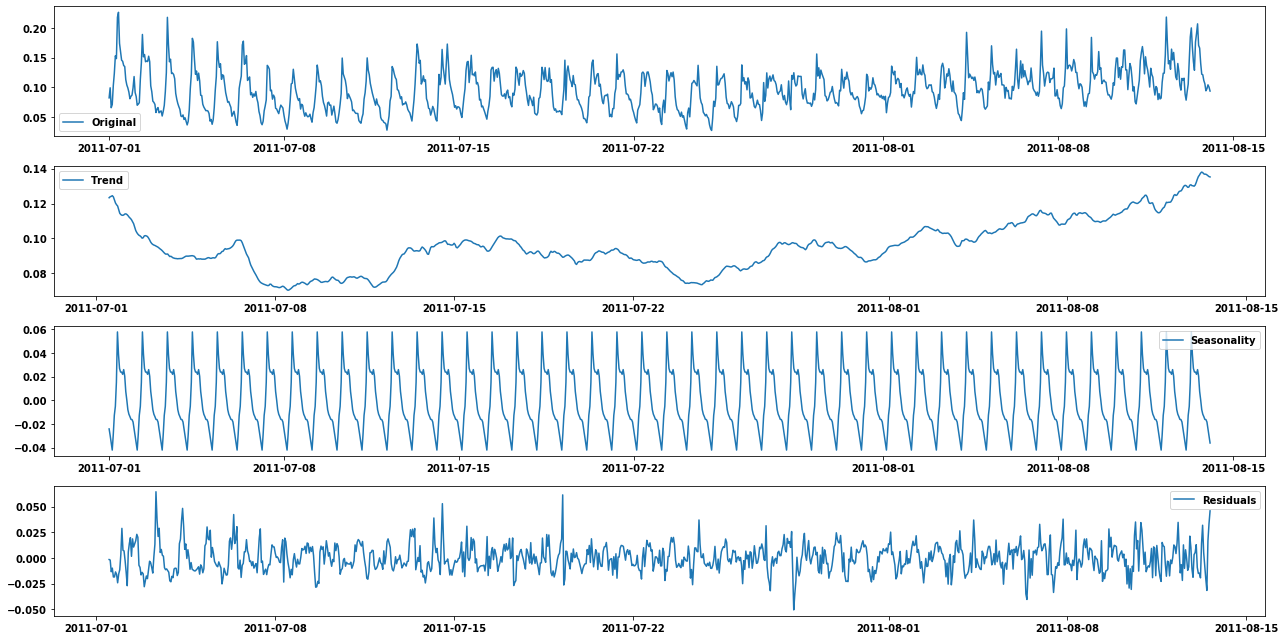

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train_ts, model='additive', freq=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualize decomposition
plt.figure(figsize=(18,9))
plt.subplot(411)
plt.plot(train_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Parameter Selection
There are 3 parameters for ARIMA model and 4 additional parameters for SARIMA models. These parameters are:
* **Autoregressive (*p*):** The amount of lagged timesteps
* **Integral (*d*):** The differencing period
* **Moving Average (*q*):** The amount of lagged errors to carryover (i.e. learning from past mistakes)
* **Seasonal Autoregressive (*P*):** Similar to *p* but with each lag = seasonal period
* **Seasonal Integral (*D*):** The number of seasonal steps used for differencing
* **Seasonal Moving Average (*q*):** Similar to *q* but with each lag = seasonal period
* **Seaonal Frequency (*S*):** the amount of consequetive timesteps constituting a season (e.g. 24 hours in a day, 7 days in a week, etc.)

These parameters can be subjectively selected by inspecting the n-lag *Autocorrelation* and *Partial Autocorrelation* plots of the decomposed noise
General rules of thumb for selecting these parameters are available on the following link: https://people.duke.edu/~rnau/arimrule.htm

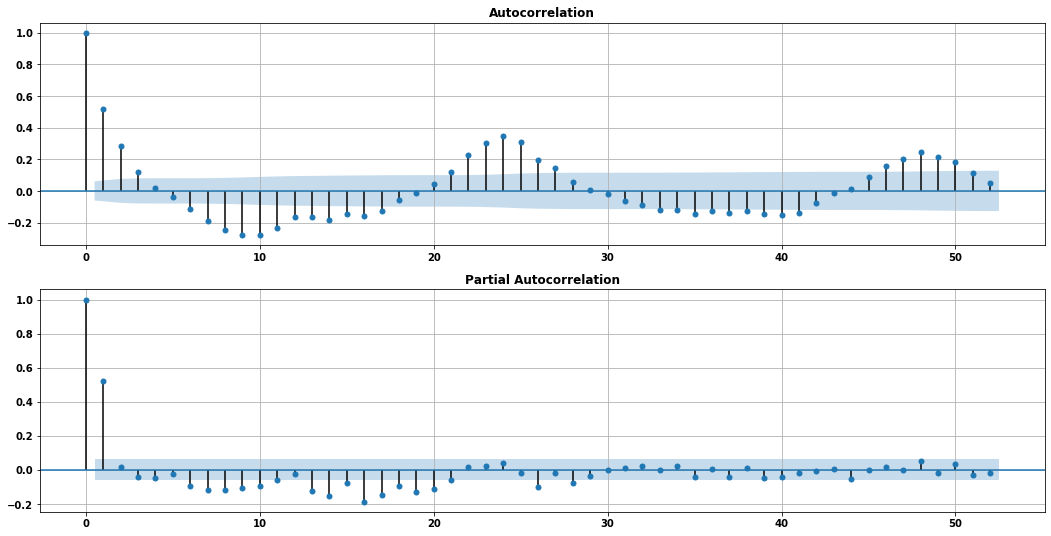

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

resid = residual.dropna()

plt.figure(figsize=(18,9))
plt.subplot(211)
plot_acf(resid, lags=52, ax=plt.gca())
plt.grid()
plt.subplot(212)
plot_pacf(resid, lags=52, ax=plt.gca())
plt.grid()
plt.show()

A subjective interpretation of these plots indicates:
* A lag of 1 for AR parameter
* First-order differencing for I
* A lag of 3 for MA parameter
* A seasonal lag of 2 for SAR
* A seasonal lag of 0 for SMA
* First-order differencing for SI

# Model Fitting
Due to the strong observed seasonality (every 24 timestamps), SARIMA would be an ideal model of choice and performs better than ARIMA

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import time

model = SARIMAX(train_ts, order=(1, 1, 3), seasonal_order=(2, 1, 0, 24))
start = time.time()
model_fit = model.fit(dis=0)
print('fitting complete after {} seconds'.format(time.time()-start))

fitting complete after 29.97715663909912 seconds


In [19]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                cpc   No. Observations:                 1059
Model:             SARIMAX(1, 1, 3)x(2, 1, 0, 24)   Log Likelihood                3020.043
Date:                            Sat, 05 Oct 2019   AIC                          -6026.086
Time:                                    18:25:45   BIC                          -5991.497
Sample:                                07-01-2011   HQIC                         -6012.961
                                     - 08-14-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5366      0.291     -1.845      0.065      -1.107       0.033
ma.L1          0.0006      0.290      0.002      0.998      -0.568       0.569
ma.L2         -0.4958      0.167     -2.972      0.003      -0.823      -0.169
ma.L3         -0.1895      0.063     -2.998      0.003      -0.313      -0.066
ar.S.L24      -0.6015      0.026    -23.467      0.000      -0.652      -0.551
ar.S.L48      -0.2885      0.028    -10.194      0.000      -0.344      -0.233
sigma2         0.0002    5.4e-06     31.105      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       86.80   Jarque-Bera (JB):               153.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.08
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Forecasting
Generate forecast for the future and convert forecasts to pandas format for easier inspection and plotting

In [15]:
f_steps = val_ts.shape[0]
results = model_fit.get_forecast(f_steps)

forecasts = pd.concat([results.predicted_mean, results.conf_int(alpha=0.05)], axis=1) 
forecasts.columns = ['Forecasts', 'Lower 95% CI', 'Upper 95% CI']

forecasts.head()

,Forecasts,Lower 95% CI,Upper 95% CI
2011-08-14 03:00:00,0.084992,0.059580,0.110405
2011-08-14 04:00:00,0.102088,0.074073,0.130104
2011-08-14 05:00:00,0.114389,0.085629,0.143149
2011-08-14 06:00:00,0.135657,0.106544,0.164770
2011-08-14 07:00:00,0.169589,0.139945,0.199233


# Validation
Compare forecasts against the hold-out validation set

Text(0.5, 1.0, 'RMSE: 0.001634420146630526')

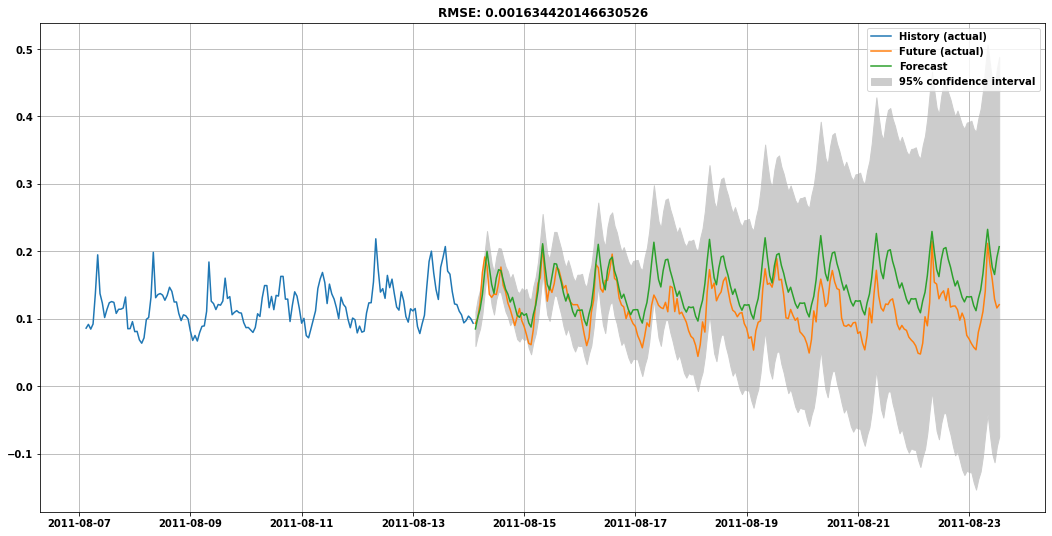

In [18]:
rmse = ((val_ts.values - results.predicted_mean)**2).mean()

plt.figure(figsize=(18,9))
plt.plot(train_ts[-24*7:], label='History (actual)')
plt.plot(val_ts, label='Future (actual)')
plt.plot(forecasts['Forecasts'], label='Forecast')
plt.fill_between(forecasts.index, forecasts['Lower 95% CI'], forecasts['Upper 95% CI'], color='0.8',label='95% confidence interval')
plt.legend()
plt.grid()
plt.title('RMSE: '+ str(rmse))